In [ ]:
validation_path='/content/drive/MyDrive/balanced dataset/validationT'

In [ ]:
%cd /content/drive/MyDrive/balanced dataset


/content/drive/MyDrive/balanced dataset


In [ ]:
!pwd

/content/drive/MyDrive/cleaned dataset


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from PIL import Image

from torch import nn
from torchvision import transforms
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x



In [ ]:
class_names = ['elephant', 'nonelephant']
vit = ViT(num_classes=len(class_names))

model = vit

In [ ]:
# for VIT
from helper_functions import set_seeds
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# 2. Setup a ViT model instance with pretrained weights
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
for parameter in model.parameters():
    parameter.requires_grad = False

class_names = ['elephant','nonelephant']
set_seeds()
model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
model.load_state_dict(torch.load( 'epoch_100_trained_model.pth',map_location ='cpu'))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 112MB/s]


<All keys matched successfully>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


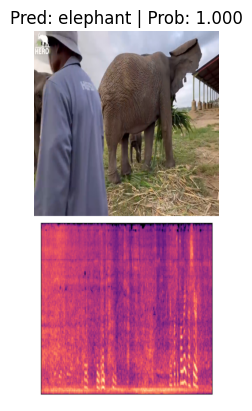

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/balanced dataset/validationT/elephant/An Unexpected Meeting Between Baby Orphan Elephant Phabeni & Setombe and Klaserie10.png"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import os
import glob
import torch
from torchvision import transforms
from PIL import Image

def get_image_files(directory):
    # Define supported image extensions
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp']

    # Initialize list to store image file paths
    image_files = []

    # Iterate through each image extension and search for files
    for ext in image_extensions:
        # Use glob to find files with the current extension
        image_files.extend(glob.glob(os.path.join(directory, ext)))

    return image_files

def predict_class(model, image_path, class_names, image_size=(224, 224), transform=None, device='cuda'):
    # Load the image
    img = Image.open(image_path)

    # Define transformation if not provided
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    # Ensure model is on the correct device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.inference_mode():
        # Transform and add an extra dimension to image
        transformed_image = transform(img).unsqueeze(dim=0).to(device)

        # Make prediction
        prediction = model(transformed_image)

        # Get predicted class
        predicted_class_index = torch.argmax(prediction, dim=1).item()
        predicted_class = class_names[predicted_class_index]

    return predicted_class


In [ ]:
def checkclass(predclass):
  if predclass == 'nonelephant':
    return 0
  else:
    return 1

In [ ]:
elephant_pred=[]
directory_path_elephant = '/content/drive/MyDrive/balanced dataset/validationT/elephant'
image_files_elephant = get_image_files(directory_path_elephant)
for i in image_files_elephant:
  elephant_pred.append(checkclass(predict_class(model, i, class_names)))

In [ ]:
nonelephant_pred=[]
directory_path_nonelephant = '/content/drive/MyDrive/balanced dataset/validationT/nonelephant'
image_files_nonelephant = get_image_files(directory_path_nonelephant)
for i in image_files_nonelephant:
  nonelephant_pred.append(checkclass(predict_class(model, i, class_names)))

In [ ]:
# making ground truth
num_of_nonelephant = len(image_files_elephant)
num_of_elephant = len(image_files_nonelephant)
print(num_of_nonelephant,num_of_elephant)
non_elephant_y=[0 for i in range(num_of_nonelephant)]
elephant_y =[1 for i in range(num_of_elephant)]


84 81


In [ ]:
y_test = non_elephant_y+elephant_y
y_pred = nonelephant_pred+elephant_pred

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
cm = confusion_matrix(y_test, y_pred)

# Compute F1 score
f1 = f1_score(y_test, y_pred)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Confusion Matrix:
[[78  6]
 [ 2 79]]
F1 Score: 0.9518072289156626
Accuracy: 0.9515151515151515


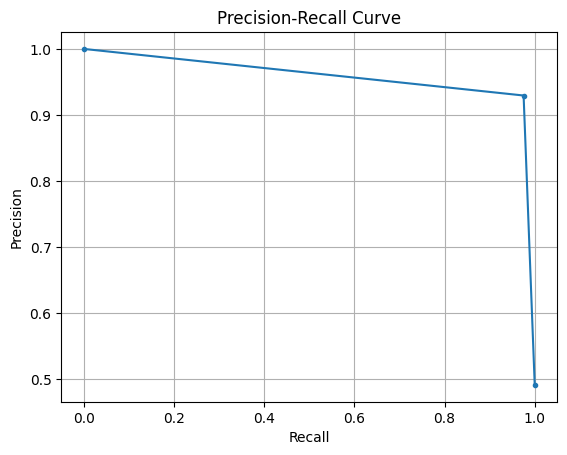

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted probabilities of the positive class
# true_labels = true labels of the test set
# predicted_probs = predicted probabilities of the positive class for each instance in the test set

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
cm = confusion_matrix(y_test, y_pred)

# Compute F1 score
f1 = f1_score(y_test, y_pred)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Confusion Matrix:
[[78  6]
 [ 2 79]]
F1 Score: 0.9518072289156626
Accuracy: 0.9515151515151515


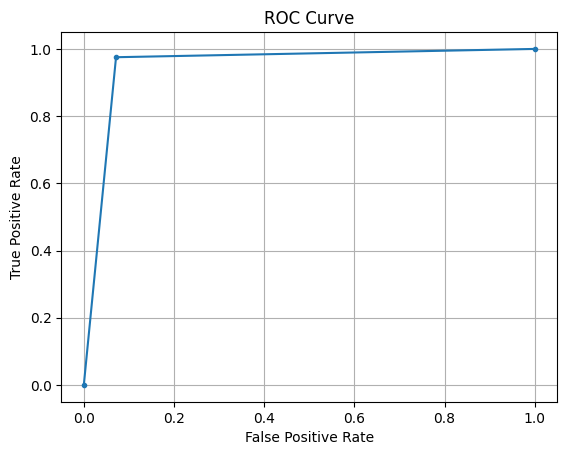

AUC: 0.9519400352733686


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute AUC
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

print("AUC:", auc)

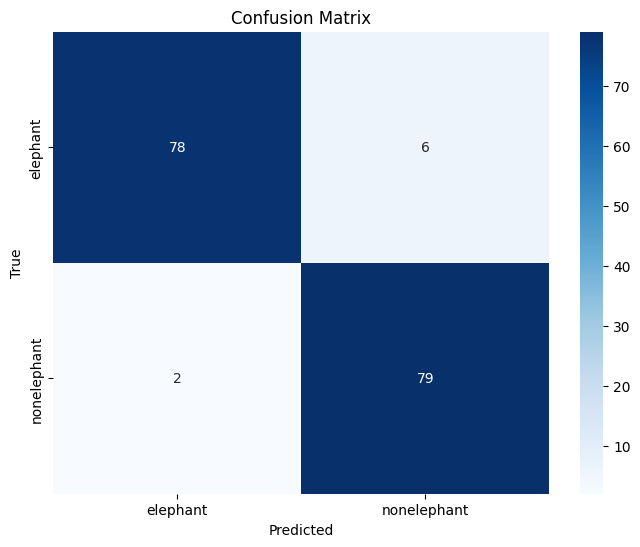

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    """Plot the confusion matrix.

    Args:
        true_labels (array-like): True labels of the test set.
        predicted_labels (array-like): Predicted labels of the test set.
        classes (list): List of class names.
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have true labels and predicted labels
# true_labels = true labels of the test set
# predicted_labels = predicted labels of the test set
# classes = list of class names

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names)
